# Sentiment Analysis of Amazon Product Reviews

By Aakash Madabhushi

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install rake_nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=c3730a6c311f7c6fefc50efd6549bb0713e00a62274f1c94dca4f69fedfaef7c
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


### Importing the Relevant Packages

In [4]:
import nltk
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
# from tf.keras.utils import to_categorical
from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
import re
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
import gzip
import rake_nltk as rn
nltk.download('stopwords')
import numpy as np
set(stopwords.words('english'))
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Loading and Exploring the Dataset

In [5]:
with tf.device('/device:GPU:0'):
    read_musical = pd.read_json('/content/drive/MyDrive/CS 481 - Natural Language Understanding/Project/Musical_Instruments.json',lines=True)
    read_digital_music = pd.read_json('/content/drive/MyDrive/CS 481 - Natural Language Understanding/Project/Digital_Music.json',lines=True)
    read_video_games = pd.read_json('/content/drive/MyDrive/CS 481 - Natural Language Understanding/Project/Video_Games.json',lines=True)


In [6]:
read_review = pd.concat([read_musical,read_digital_music,read_video_games])

In [7]:
#Viewing the Dataframe
read_review.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN
2,5,NaN,True,"03 14, 2017",AUPWU27A7X5F6,0470536454,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,1489449600,NaN
3,4,NaN,True,"02 14, 2017",A1N69A47D4JO6K,0470536454,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,Four Stars,1487030400,NaN
4,5,NaN,True,"01 29, 2017",AHTIQUMVCGBFJ,0470536454,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN


In [8]:
read_review.shape

(5661961, 12)

In [9]:
# check empty cells
read_review.isnull().sum()

overall                 0
vote              4850575
verified                0
reviewTime              0
reviewerID              0
asin                    0
style             2358637
reviewerName          484
reviewText           4023
summary              1726
unixReviewTime          0
image             5596900
dtype: int64

In [10]:
read_review = read_review[['overall','reviewText']]

In [11]:
read_review = read_review.reset_index()

In [12]:
read_review.shape

(5661961, 3)

In [13]:
read_review.head()

,index,overall,reviewText
0,0,5,Crocheting for Dummies by Karen Manthey & Susa...
1,1,4,Very helpful...
2,2,5,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO
3,3,4,My girlfriend use quite often
4,4,5,Arrived as described. Very happy.


In [14]:
read_review.isnull().sum()

index            0
overall          0
reviewText    4023
dtype: int64

In [15]:
read_review = read_review.dropna()

In [16]:
read_review.overall=read_review.overall.astype(int)

In [17]:
#Gets rid of the rows with an overall rating of 3.0 since it is a neutral value 
read_review = read_review[read_review['overall'] !=3]

In [18]:
#Encodes binary value(1 for positive sentiment(4.0-5.0) and 0 for negative sentiment(1.0-2.0))
def sentiment(n):
  return 1 if n >=4 else 0

In [19]:
read_review['sentiment'] = read_review['overall'].apply(sentiment)

In [20]:
read_review[read_review['overall'] == 1].head()

,index,overall,reviewText,sentiment
100,100,1,Save yourself the oftalmologist's visit and bu...,0
160,160,1,"This book was not what I thought, there should...",0
163,163,1,I was looking for basic beginner help and bet...,0
206,206,1,The illustrations are too confusing for someon...,0
213,213,1,"<a data-hook=""product-link-linked"" class=""a-li...",0


In [21]:
read_review.head()

,index,overall,reviewText,sentiment
0,0,5,Crocheting for Dummies by Karen Manthey & Susa...,1
1,1,4,Very helpful...,1
2,2,5,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1
3,3,4,My girlfriend use quite often,1
4,4,5,Arrived as described. Very happy.,1


In [22]:
np.random.seed(100000)

In [23]:
read_review.reviewText=read_review.reviewText.astype(str)

### Preprocessing

In [24]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def clean_text(df,flg_stemm=False, flg_lemm=True):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['reviewText']):
        
        # expand the contracted words
        review_text = decontracted(review_text)
        
        #remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)

        # The Snowball Stemmer requires that you pass a language parameter
        s_stemmer = SnowballStemmer(language='english')
        review_text = s_stemmer.stem(review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

In [25]:
with tf.device('/device:GPU:0'):
    read_review['cleanedText'] = clean_text(read_review)

  1%|          | 40264/5282079 [00:11<24:07, 3622.18it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/dp/B003TN088Y/ref=cm_cr_ryp_prd_ttl_sol_43" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
  1%|▏         | 75864/5282079 [00:21<22:20, 3883.16it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B0002E1G5C?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_51" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
  4%|▎         | 192923/5282079 [00:54<23:05, 3672.88it/s]/usr/local/lib/python3.7/dist-packages/b

In [26]:
read_review.head(100)

,index,overall,reviewText,sentiment,cleanedText
0,0,5,Crocheting for Dummies by Karen Manthey & Susa...,1,crocheting for dummies by karen manthey susa...
1,1,4,Very helpful...,1,very helpful
2,2,5,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1,easy to understand and a prompt service too
3,3,4,My girlfriend use quite often,1,my girlfriend use quite often
4,4,5,Arrived as described. Very happy.,1,arrived as described very happy
...,...,...,...,...,...
98,98,5,very good,1,very good
99,99,5,Good book,1,good book
100,100,1,Save yourself the oftalmologist's visit and bu...,0,save yourself the oftalmologist is visit and b...
101,101,5,I took this out of the library first and enjoy...,1,i took this out of the library first and enjoy...


In [27]:
# with tf.device('/device:GPU:0'): 
#     read_review['word_count'] = read_review["cleanedText"].apply(lambda x: len(str(x).split(" ")))
#     read_review['char_count'] = read_review["cleanedText"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
#     read_review['sentence_count'] = read_review["cleanedText"].apply(lambda x: len(str(x).split(".")))
#     read_review['avg_word_length'] = read_review['char_count'] / read_review['word_count']
#     read_review['avg_sentence_lenght'] = read_review['word_count'] / read_review['sentence_count']
#     read_review.head()

### Random Under-Sampling

In [28]:
count_1,count_0 = read_review['sentiment'].value_counts()
# print(count_0)

class_0 = read_review[read_review['sentiment'] == 0]
class_1 = read_review[read_review['sentiment'] == 1]

print('0: ', class_0.shape)
print('1: ',class_1.shape)

0:  (704592, 5)
1:  (4577487, 5)


In [29]:
class_1_underSample = class_1.sample(count_0)

test_underSample = pd.concat([class_0,class_1_underSample],axis=0)

print(test_underSample['sentiment'].value_counts())

1    704592
0    704592
Name: sentiment, dtype: int64


In [30]:
test_underSample.head() 

,index,overall,reviewText,sentiment,cleanedText
67,67,2,I have never really used it. I don't really ge...,0,i have never really used it i do not really g...
68,68,2,Package arrived in the time frame that was gua...,0,package arrived in the time frame that was gua...
91,91,2,This book is just okay. Crochet step-by-step b...,0,this book is just okay crochet step by step b...
100,100,1,Save yourself the oftalmologist's visit and bu...,0,save yourself the oftalmologist is visit and b...
160,160,1,"This book was not what I thought, there should...",0,this book was not what i thought there should...


### Feature Engineering

Using TFidf vectorizer for transforming the reviews into numerical feature vectors (vectorization) that the computer can understand

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [105]:
X = test_underSample['cleanedText'].values
y = test_underSample['sentiment'].values

In [106]:
with tf.device('/device:GPU:0'):    
    ct_vectorizer = CountVectorizer(binary=True)
    # print(X.toarray())
  

In [107]:
#eliminate NaN elements of y
i = 0
while(i < len(y)):
    if type(y[i]) == float:
        X = np.delete(x, i)
        y = np.delete(y, i)
        i += -1
    i += 1

In [108]:
print(X)

['i have never really used it  i do not really get these  dummies  books '
 'package arrived in the time frame that was guaranteed however the front cover i torn up  i love my books and this is a great annoyance to me   if you purchase  just be prepared it may arrived damaged '
 'this book is just okay  crochet step by step by sally harding is much better for the beginner  priscilla teitenberg'
 ...
 'we got this for our   year old son who is showing an interest in music  the light up keys are perfect for him to start to learn without having to read music yet  he has some short term success playing tunes that keeps him motivated to learn more  i have even picked up playing again even though i have not since i was young  there are so many demo songs and it comes with the sheet music so it is been fun to start playing again  it definitely is not the same as a piano since you can not play forte or pianoforte or crescendo  etc   and i do miss that since it brings much more feeling to a pie

In [109]:
print(y)

[0 0 0 ... 1 1 1]


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [112]:
with tf.device('/device:GPU:0'):       
    X_train = ct_vectorizer.fit_transform(X_train)
    X_test = ct_vectorizer.transform(X_test)


In [113]:
print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (1056888, 226738), y_train : (1056888,)
Testing data: X_test : (352296, 226738), y_test : (352296,)


## Model Training

Logistic Regression: regression with output constrained between 0 and 1 with a sigmoid logistic function, as we see here, combine the linear regression with a logistic function, we get the logistic regression function:

$$ 
    P(y=1|\vec{x}) = \frac{1}{1 + e^{(- t)}}  = \frac{1}{1 + e^{(-\sum_i\beta_i x_i)}} 
$$
$x_i$ is value of feature $i$ in an instance (count of a word)
$\beta_i$ is the real-valued model parameter associated with feature $i$
E.g., high $\beta_i$ means feature $i$ is predictive of positive class ($y=1$)
$P(y=1|\vec{x})$ is the probability of being positive
If $P(y=1|\vec{x}) &gt;= .5$, classify as positive; Otherwise, negative.

In [114]:
from sklearn.linear_model import LogisticRegression

In [115]:
with tf.device('/device:GPU:0'):     
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train,y_train)

In [116]:
y_pred_test = clf.predict(X_test)
print("Logistic Regression Accuracy Score: ",accuracy_score(y_pred_test,y_test)*100)
cm = confusion_matrix(y_test, y_pred_test)
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])
print("FPR =", (cm[0][1])/(cm[0][1]+cm[1][1]))
print(classification_report(y_test,y_pred_test))

Logistic Regression Accuracy Score:  91.28119535844857
True positive =  159456
False positive =  16254
False negative =  14462
True negative =  162124
FPR = 0.09112110237809595
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    175710
           1       0.91      0.92      0.91    176586

    accuracy                           0.91    352296
   macro avg       0.91      0.91      0.91    352296
weighted avg       0.91      0.91      0.91    352296



In [117]:
y_pred_prob_test = clf.predict_proba(X_test)
print(y_pred_prob_test)

[[9.99983665e-01 1.63347508e-05]
 [9.67866136e-01 3.21338643e-02]
 [1.52916292e-01 8.47083708e-01]
 ...
 [9.93494659e-01 6.50534103e-03]
 [5.97775635e-01 4.02224365e-01]
 [8.72628428e-01 1.27371572e-01]]


### Out of Domain Prediction


In [118]:
# from sklearn.model_selection import cross_val_score
# with tf.device('/device:GPU:0'): 
#     scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
#     print(scores)

In [119]:
rev_1 = "This book takes one through forty of his photographs documenting in his words his thoughts, his actions and the equipment he used. in my opinion this is a helpful technical book regarding the circumstances surrounding the production of a great artist's works. If you are looking for wonderful Ansel Adams book of photographs exquisitely reproduced, there are much better books that Ansel Adams produced than this one."
rev_2 = "This product needs be thrown in the boxing ring to get an ass whopping from all of Joe Rogan's Onnit athletes. "
rev_3 = "It a good quality fresh man's scent without too much floral nonsense. "
rev_4 = "Let me tell you, I was super excited for the launch of the new FireTV Stick with its leading edge technology and processing power. Well, it’s got that but there’s a couple bug, game breaking problems I have with this thing."
rev_5 = "I love everything about this laptop... EXCEPT THE WEBCAM. I bought this to conduct telehealth sessions and this one thing matters more than anything and it's the one truly horrible thing about it."
rev_6 = "It was brilliant. I heartily recommend it! Mainly because it is so very funny. The story of an incompetent detective who gets a weird case (containing a time machine)."
rev_7 = "I absolutely love this jacket. Reminds me of the one I had in the 70's. Great for cold climate. I bought one size larger to accommodate layering."
rev_8 = "I gave it a 1 star cause it makes a loud humming noise which drove me crazy. The adhesion on the strip was not good at all every time i would put it up it would fall down. Would not recommend this."
rev_9 = "I was very disappointed to have my uranium confiscated at the airport. It was a gift for my son for his birthday. Also, I'm in prison now, so that's not good either."
rev_10 = "Bulb cracked on day 2. Horn takes rapid squeeze to make any sound. The big bulb does not make big sound, it’s no louder than a $7 bicycle horn but does have a train horn pitch. Kind of sad because it’s a hard to believe you get a brass anything for the money."


review_list = {'reviewText': [rev_1, rev_2, rev_3, rev_4, rev_5, rev_6,
                        rev_7, rev_8, rev_9, rev_10]}
review_df = pd.DataFrame(data=review_list)                     

In [120]:
with tf.device('/device:GPU:0'):  
    review_df['cleantext'] = clean_text(review_df)

100%|██████████| 10/10 [00:00<00:00, 1691.25it/s]


In [121]:
review_df.head()

,reviewText,cleantext
0,This book takes one through forty of his photo...,this book takes one through forty of his photo...
1,This product needs be thrown in the boxing rin...,this product needs be thrown in the boxing rin...
2,It a good quality fresh man's scent without to...,it a good quality fresh man is scent without t...
3,"Let me tell you, I was super excited for the l...",let me tell you i was super excited for the l...
4,I love everything about this laptop... EXCEPT ...,i love everything about this laptop except ...


In [122]:
print(review_df['cleantext'].values)

['this book takes one through forty of his photographs documenting in his words his thoughts  his actions and the equipment he used  in my opinion this is a helpful technical book regarding the circumstances surrounding the production of a great artist is works  if you are looking for wonderful ansel adams book of photographs exquisitely reproduced  there are much better books that ansel adams produced than this one '
 'this product needs be thrown in the boxing ring to get an ass whopping from all of joe rogan is onnit athletes '
 'it a good quality fresh man is scent without too much floral nonsense '
 'let me tell you  i was super excited for the launch of the new firetv stick with its leading edge technology and processing power  well  it s got that but there s a couple bug  game breaking problems i have with this thing '
 'i love everything about this laptop    except the webcam  i bought this to conduct telehealth sessions and this one thing matters more than anything and it is t

In [123]:
pred_tfidf = ct_vectorizer.transform(review_df['cleantext'].values)
print(pred_tfidf)
predictions = clf.predict(pred_tfidf)
review_df['clf_predictions'] = predictions

  (0, 1999)	1
  (0, 2241)	1
  (0, 7567)	1
  (0, 8489)	1
  (0, 10331)	1
  (0, 11395)	1
  (0, 19635)	1
  (0, 23066)	1
  (0, 23118)	1
  (0, 34555)	1
  (0, 54769)	1
  (0, 63889)	1
  (0, 67570)	1
  (0, 73818)	1
  (0, 74370)	1
  (0, 83519)	1
  (0, 88343)	1
  (0, 89389)	1
  (0, 90795)	1
  (0, 94636)	1
  (0, 96211)	1
  (0, 101113)	1
  (0, 116131)	1
  (0, 129813)	1
  (0, 131157)	1
  :	:
  (9, 73818)	1
  (9, 79843)	1
  (9, 87169)	1
  (9, 87959)	1
  (9, 92182)	1
  (9, 102113)	1
  (9, 108115)	1
  (9, 116573)	1
  (9, 119025)	1
  (9, 127863)	1
  (9, 134801)	1
  (9, 135709)	1
  (9, 138269)	1
  (9, 139267)	1
  (9, 149011)	1
  (9, 159746)	1
  (9, 171185)	1
  (9, 184973)	1
  (9, 187352)	1
  (9, 195508)	1
  (9, 198390)	1
  (9, 198551)	1
  (9, 201402)	1
  (9, 203262)	1
  (9, 224973)	1


In [124]:
review_df.head()

,reviewText,cleantext,clf_predictions
0,This book takes one through forty of his photo...,this book takes one through forty of his photo...,1
1,This product needs be thrown in the boxing rin...,this product needs be thrown in the boxing rin...,0
2,It a good quality fresh man's scent without to...,it a good quality fresh man is scent without t...,1
3,"Let me tell you, I was super excited for the l...",let me tell you i was super excited for the l...,1
4,I love everything about this laptop... EXCEPT ...,i love everything about this laptop except ...,1


### ROC Curve

In [125]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred_prob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

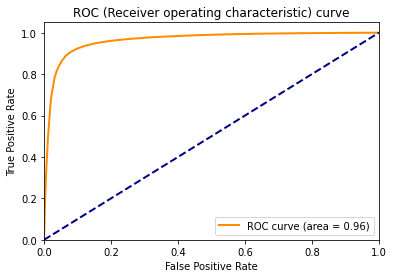

In [126]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve

In [127]:

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob_test[:,1], pos_label=1)

In [128]:
print(precision)

[0.50168473 0.50168331 0.50168474 ... 1.         1.         1.        ]


In [129]:
print(recall)

[1.00000000e+00 9.99994337e-01 9.99994337e-01 ... 4.41711121e-04
 3.45440748e-04 0.00000000e+00]


In [130]:
print(thresholds)

[1.17080124e-14 1.20433848e-14 1.28725561e-14 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


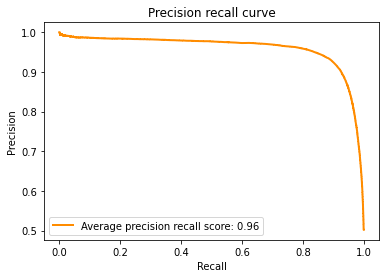

In [131]:

from sklearn.metrics import average_precision_score

plt.plot(recall, precision, color='darkorange', lw=lw, label='Average precision recall score: %0.2f' % average_precision_score(y_test, y_pred_prob_test[:,1]))

plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [132]:
df_test = read_review.iloc[352296]
df_test.loc['pred_label'] = y_pred_test
pd.options.mode.chained_assignment = None
df_test.head(3)

index                                                    377001
overall                                                       1
reviewText    I was expecting to receive a full set of strin...
Name: 377001, dtype: object

In [133]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(ct_vectorizer.get_feature_names(), clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

# words like "refreshing, hooked, superb" are reliable evidence of indicating positive sentiments

Top positive features:


[('amaz', 3.429),
 ('excelent', 3.288),
 ('awesom', 3.205),
 ('brainier', 3.059),
 ('beauti', 2.998),
 ('excelente', 2.951),
 ('nitpick', 2.948),
 ('pleasantly', 2.917),
 ('excel', 2.916),
 ('regrets', 2.776)]

In [134]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('somethjng', -3.993),
 ('garbag', -3.936),
 ('terribl', -3.758),
 ('ntokc', -3.705),
 ('horribl', -3.67),
 ('terr', -3.347),
 ('amateurish', -3.343),
 ('brok', -3.301),
 ('worst', -3.181),
 ('horr', -3.094)]

To conclude, with the model's accuracy at about 91%, it was able to discriminate the positive and negative sentiments. For example: From my findings using out of domain prediction, the model was able to predict and recognize sentences that were more positive(1) and some that were negative(0).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


with tf.device('/device:GPU:0'): 
    vectorizer = CountVectorizer()
    logistic = LogisticRegression(max_iter=10000) # , tol=0.1

    # build a pipeline
    pipe = Pipeline(steps = [
        ('vectorizer', vectorizer),
        ('classifier', logistic)])

    # creat a dictionary of model parameters and corresponding values
    # For example, in countvectorizer, we want to explore the suitable value for min_df, select from 1,3,5,10
    param_grid = {
        'vectorizer__min_df': [1, 3, 5],
        'vectorizer__max_df': [0.7, 0.8, 0.9]}

    # run GridSearchCV, cv, f1
    search_result = GridSearchCV(pipe, param_grid, cv=5, scoring='f1').fit(X, y)
    print(search_result)


    print("Best parameter (CV score=%0.3f):" % search_result.best_score_) # scoring: accuracy by default
    print(search_result.best_params_)
    # with 5 fold cv, the best f1 score is 0.887, and the corresponding parameter values are as follows: